# <center>Clusterização - Cartão de Crédito</center>

<center> <img src="https://img.freepik.com/vetores-gratis/pessoas-segurando-credito-cartoes-ilustracao_53876-6375.jpg" alt="some text" width=500 height=300></center>

<p>O conjunto de dados foi retirado do <a href='https://www.kaggle.com/datasets/arjunbhasin2013/ccdata'>Kaggle</a>, ele mostra o comportamento de usuários de cartão de créditos ativos, nos últimos 6 meses. A ideia é classificar esses clientes em grupos, encontrando características que os definem, e a partir do agrupamento, encaminhar para o setor de marketing, onde novas campanhas possam ser elaboradas. </p>

### Descrição das Variáveis:

Variáveis | Descrição
----------|----------
CUSTID    |Identificação do titular do cartão de crédito
BALANCE   |Saldo do valor restante em sua conta para fazer compras
BALANCEFREQUENCY|Com que frequência o Balanço é atualizado, pontuação entre 0 e 1 (1 = é atualizado com frequência,     0 = não é atualizado com frequência)
PURCHASES|Quantidade de compras feitas na conta
ONEOFFPURCHASES|Valor máximo de compra feito de uma só vez
INSTALLMENTSPURCHASES|Valor da compra parcelado
CASHADVANCE|Dinheiro adiantado dado pelo cliente
PURCHASESFREQUENCY |Com que frequência as compras estão sendo feitas, pontuação entre 0 e 1 (1 = comprado com frequência, 0 = não comprado com frequência)
ONEOFFPURCHASESFREQUENCY |Com que frequência as compras acontecem de uma só vez (1 = compradas com frequência, 0 = compradas com pouca frequência)
PURCHASESINSTALLMENTSFREQUENCY|Com que frequência as compras parceladas estão sendo feitas (1 = feito com frequência, 0 = feito com pouca frequência)
CASHADVANCEFREQUENCY|Com que frequência o dinheiro adiantado está sendo pago
CASHADVANCETRX|Número de transações feitas com "Cash in Advanced"
PURCHASESTRX|Número de transações de compra feitas
CREDITLIMIT|Limite de cartão de crédito por usuário
PAYMENTS|Valor do pagamento feito pelo cliente
MINIMUM_PAYMENTS|Valor mínimo de pagamentos feitos pelo cliente
PRCFULLPAYMENT|Percentual do pagamento integral pago pelo usuário
TENURE|Posse do serviço de cartão de crédito para o usuário


### Importando as bibliotecas

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

#### Lendo o Dataset e verificando as primeiras linhas

In [26]:
df = pd.read_csv('../data/raw/CC GENERAL.csv')
df_raw = df.copy()
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


#### Verificando Valores Nulos

In [6]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

##### Possível notar que as colunas CREDIT_LIMIT e MINIMUM_PAYMENTS possuem valores nulos, iremos tratar eles.

In [7]:
df.loc[(df['MINIMUM_PAYMENTS'].isnull() == True), 'MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].median()
df.loc[(df['CREDIT_LIMIT'].isnull() == True), 'CREDIT_LIMIT'] = df['CREDIT_LIMIT'].median()

##### Os valores nulos foram substituidos pela mediana das colunas, a média não foi utilizada por ter muitos outliers, deixando ela tendenciosa.

In [8]:
df.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

##### É possível identificar diversos outliers, o que pode interferir no processo de Clusterização, vamos podar os outliers

In [9]:
columns=['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS']

for c in columns:
    
    Range=c+'_RANGE'
    df[Range]=0        
    df.loc[((df[c]>0)&(df[c]<=500)),Range]=1
    df.loc[((df[c]>500)&(df[c]<=1000)),Range]=2
    df.loc[((df[c]>1000)&(df[c]<=3000)),Range]=3
    df.loc[((df[c]>1000)&(df[c]<=5000)),Range]=4
    df.loc[((df[c]>5000)&(df[c]<=10000)),Range]=5
    df.loc[((df[c]>10000)),Range]=6

In [10]:
columns=['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
        'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']

for c in columns:
    
    Range=c+'_RANGE'
    df[Range]=0
    df.loc[((df[c]>0)&(df[c]<=0.1)),Range]=1
    df.loc[((df[c]>0.1)&(df[c]<=0.2)),Range]=2
    df.loc[((df[c]>0.2)&(df[c]<=0.3)),Range]=3
    df.loc[((df[c]>0.3)&(df[c]<=0.4)),Range]=4
    df.loc[((df[c]>0.4)&(df[c]<=0.5)),Range]=5
    df.loc[((df[c]>0.5)&(df[c]<=0.6)),Range]=6
    df.loc[((df[c]>0.6)&(df[c]<=0.7)),Range]=7
    df.loc[((df[c]>0.7)&(df[c]<=0.8)),Range]=8
    df.loc[((df[c]>0.8)&(df[c]<=0.9)),Range]=9
    df.loc[((df[c]>0.9)&(df[c]<=1.0)),Range]=10

In [11]:
for c in columns:
    
    Range=c+'_RANGE'
    df[Range]=0
    df.loc[((df[c]>0)&(df[c]<=5)),Range]=1
    df.loc[((df[c]>5)&(df[c]<=10)),Range]=2
    df.loc[((df[c]>10)&(df[c]<=15)),Range]=3
    df.loc[((df[c]>15)&(df[c]<=20)),Range]=4
    df.loc[((df[c]>20)&(df[c]<=30)),Range]=5
    df.loc[((df[c]>30)&(df[c]<=50)),Range]=6
    df.loc[((df[c]>50)&(df[c]<=100)),Range]=7
    df.loc[((df[c]>100)),Range]=8

In [12]:
df.drop(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY',  'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT' ], axis=1, inplace=True)

X= np.asarray(df)

In [13]:
df.head()

,TENURE,BALANCE_RANGE,PURCHASES_RANGE,ONEOFF_PURCHASES_RANGE,INSTALLMENTS_PURCHASES_RANGE,CASH_ADVANCE_RANGE,CREDIT_LIMIT_RANGE,PAYMENTS_RANGE,MINIMUM_PAYMENTS_RANGE,BALANCE_FREQUENCY_RANGE,PURCHASES_FREQUENCY_RANGE,ONEOFF_PURCHASES_FREQUENCY_RANGE,PURCHASES_INSTALLMENTS_FREQUENCY_RANGE,CASH_ADVANCE_FREQUENCY_RANGE,PRC_FULL_PAYMENT_RANGE
0,12,1,1,0,1,0,2,1,1,1,1,0,1,0,0
1,12,4,0,0,0,5,5,4,4,1,0,0,0,1,1
2,12,4,2,2,0,0,5,2,2,1,1,1,0,0,0
3,12,4,4,4,0,1,5,0,1,1,1,1,0,1,0
4,12,2,1,1,0,0,4,2,1,1,1,1,0,0,0


#### Padronizando as variáveis

In [14]:
scale = StandardScaler()
X = scale.fit_transform(X)
X.shape

(8950, 15)

#### Decidindo o número de Clusters(Grupos)

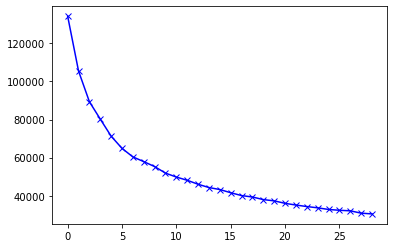

In [33]:
n_clusters=30
cost=[]
for i in range(1,n_clusters):
    kmean= KMeans(i)
    kmean.fit(X)
    cost.append(kmean.inertia_)  

plt.plot(cost, 'bx-')
plt.savefig('../cluster.png')

#### Treinando o modelo com 6 grupos

In [16]:
kmean= KMeans(6)
kmean.fit(X)
labels=kmean.labels_

In [17]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,TENURE,BALANCE_RANGE,PURCHASES_RANGE,ONEOFF_PURCHASES_RANGE,INSTALLMENTS_PURCHASES_RANGE,CASH_ADVANCE_RANGE,CREDIT_LIMIT_RANGE,PAYMENTS_RANGE,MINIMUM_PAYMENTS_RANGE,BALANCE_FREQUENCY_RANGE,PURCHASES_FREQUENCY_RANGE,ONEOFF_PURCHASES_FREQUENCY_RANGE,PURCHASES_INSTALLMENTS_FREQUENCY_RANGE,CASH_ADVANCE_FREQUENCY_RANGE,PRC_FULL_PAYMENT_RANGE,cluster
0,12,1,1,0,1,0,2,1,1,1,1,0,1,0,0,1
1,12,4,0,0,0,5,5,4,4,1,0,0,0,1,1,5
2,12,4,2,2,0,0,5,2,2,1,1,1,0,0,0,4
3,12,4,4,4,0,1,5,0,1,1,1,1,0,1,0,4
4,12,2,1,1,0,0,4,2,1,1,1,1,0,0,0,4


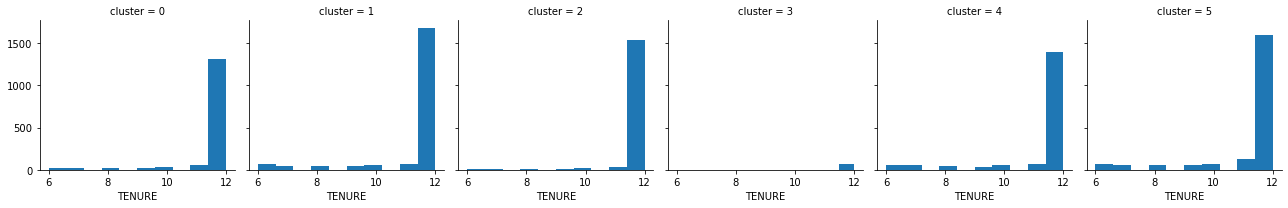

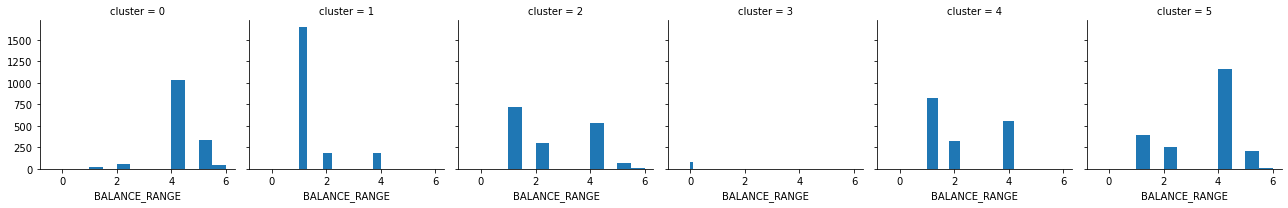

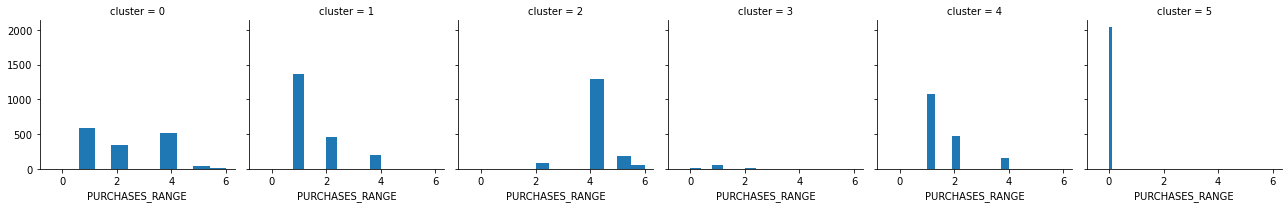

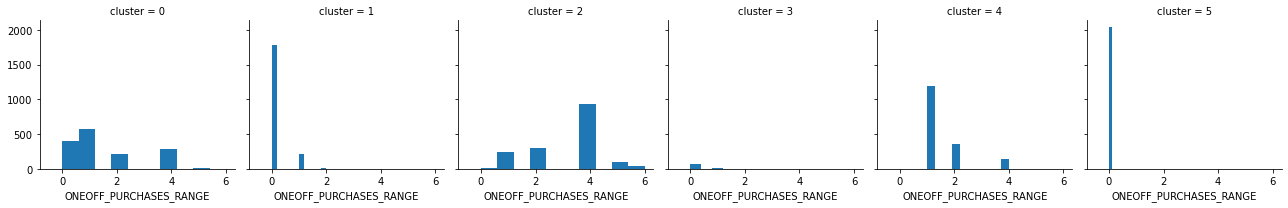

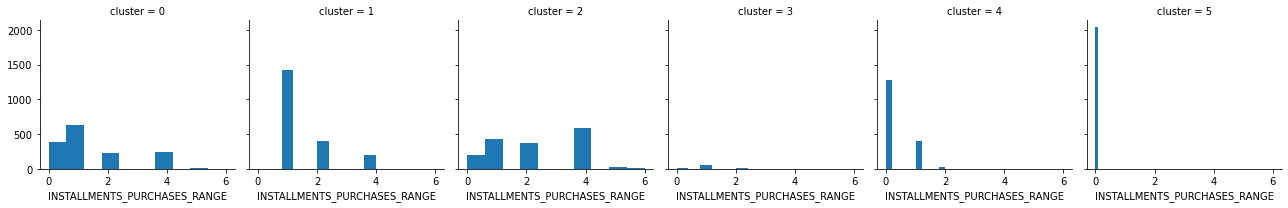

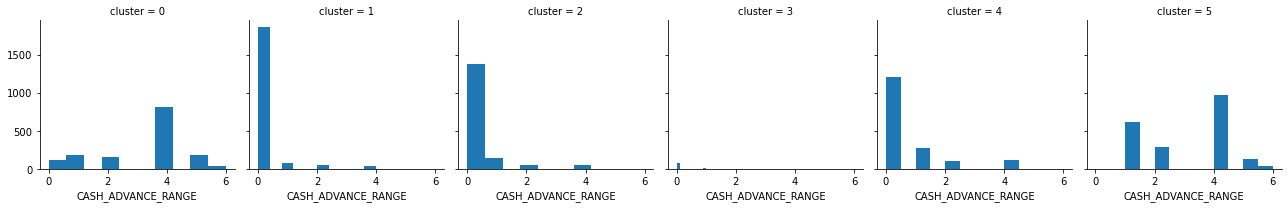

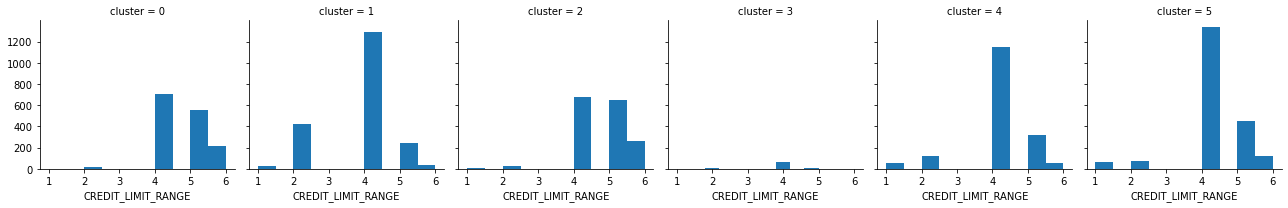

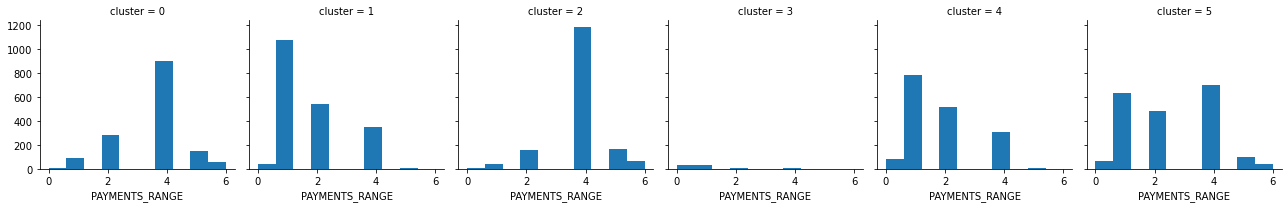

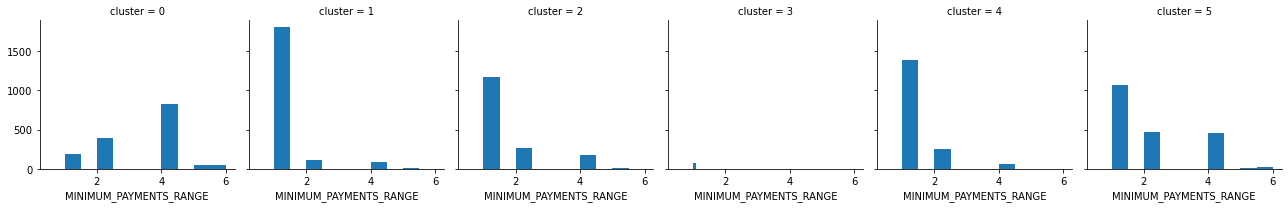

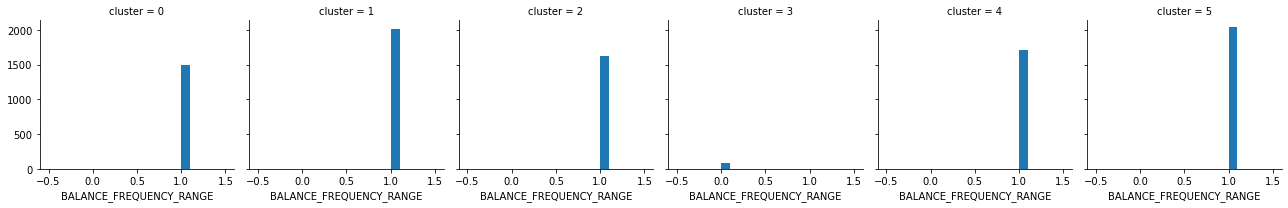

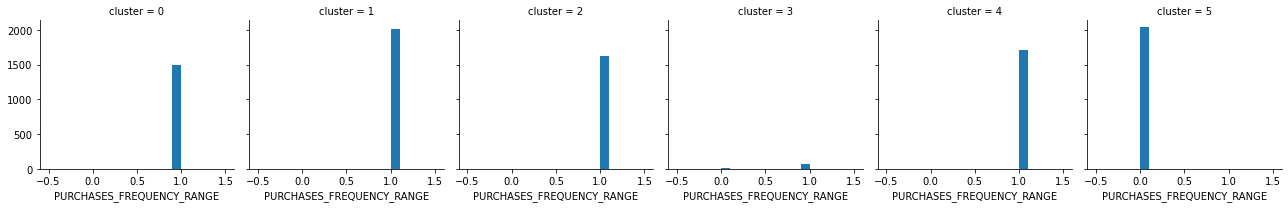

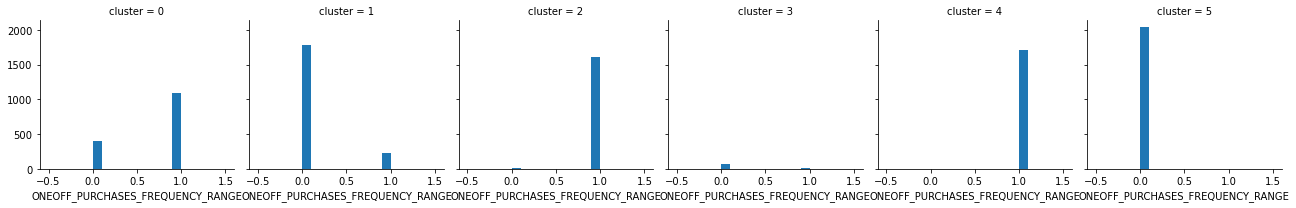

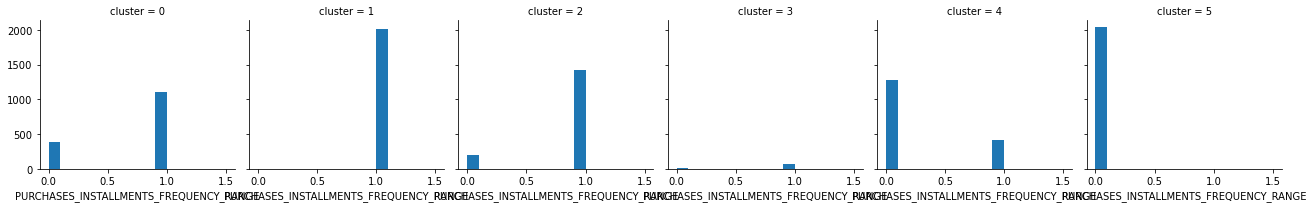

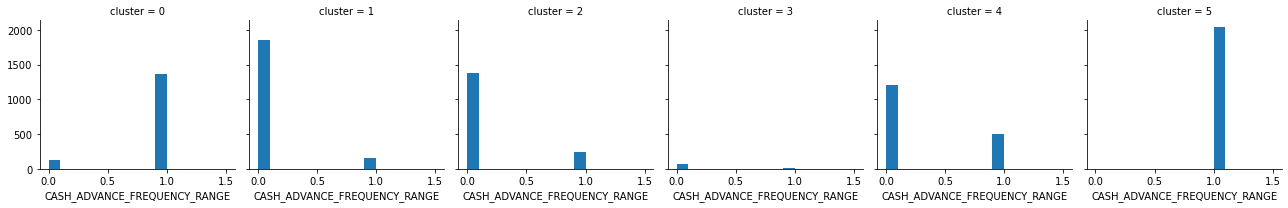

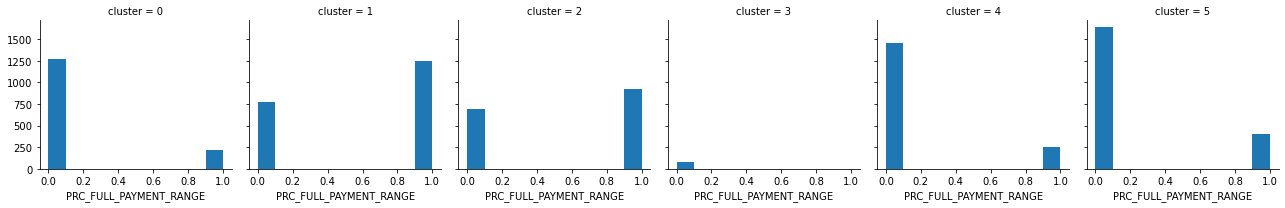

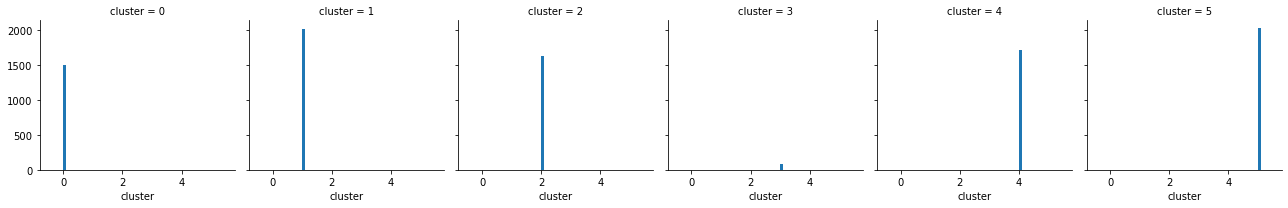

In [34]:
i = 0
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)
    plt.savefig(f'../clusters{i}.png')
    i += 1



##### Com os grupos separados pode definir algumas características 

* Grupo 0 -> Grupo que faz qualquer tipo de compra com o cartão, parcelado, a vista.
* Grupo 1 -> Grupo com pessoas devendo o cartão de crédito.
* Grupo 2 -> Grupo que compra a prazo, de forma parcelada, com mais frequência.
* Grupo 3 -> Grupo que usa o Cash in Advance, que é uma forma de antecipar o dinheiro.
* Grupo 4 -> Grupo que faz as compras com maiores valores.
* Grupo 5 -> Grupo que não gasta muito dinheiro

### <center>PCA</center>

##### Utilizamos o PCA, para reduzir a dimensionalidade do dataset, 2 dimensões, e assim mostrar graficamente a clusterização.

In [19]:
dist = 1 - cosine_similarity(X)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)

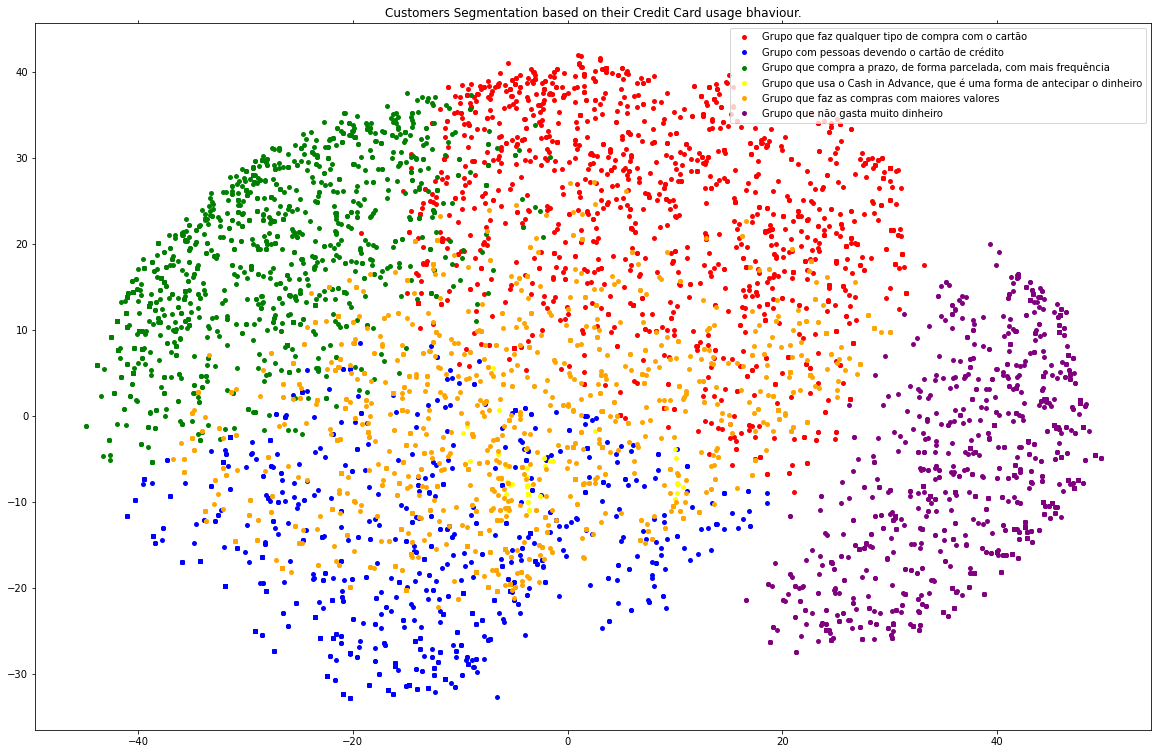

<Figure size 432x288 with 0 Axes>

In [38]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple'}

names = {0: 'Grupo que faz qualquer tipo de compra com o cartão', 
         1: 'Grupo com pessoas devendo o cartão de crédito', 
         2: 'Grupo que compra a prazo, de forma parcelada, com mais frequência', 
         3: 'Grupo que usa o Cash in Advance, que é uma forma de antecipar o dinheiro', 
         4: 'Grupo que faz as compras com maiores valores',
         5: 'Grupo que não gasta muito dinheiro'}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()

In [22]:
df_raw['CLUSTER'] = clusters['cluster']
df_raw.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,CLUSTER
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,5
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,4
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,4
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,4


In [25]:
df_raw.to_csv('../data/raw/CC GENERALC.csv', sep=';')